# Multimodality with Gemini 2.0 Flash

In [1]:
!pip install -qU \
    google-genai==0.2.2 \
    matplotlib==3.10.0 \
    pillow==11.0.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.5/111.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.9 MB/s eta 0:00:00


## Loading Images

We're going to test Gemini against a few underwater images. The content of these images is fairly challenging, they're from a relatively uncommon environment and the image quality is okay but certainly not great. However, this is a perfect test of how Gemini might perform on real-world data.


In [3]:
import os
from pathlib import Path
import requests

# check if the images directory exists
if not os.path.exists("./images"):
    os.mkdir("./images")

png_paths = [str(x) for x in Path("./images").glob("*.png")]

# check if we have expected images, otherwise download
if len(png_paths) >= 4:
    print("Images already downloaded")
else:
    print("Downloading images...")
    # download images from the web
    files = ["clown-fish.png", "dotted-fish.png", "many-fish.png", "fish-home.png"]
    for file in files:
        url = f"https://github.com/hifzazafar17/Gemini-2.0-Live-API-projects/tree/master/images/{file}?raw=true"
        response = requests.get(url, stream=True)
        with open(f"./images/{file}", "wb") as f:
            for block in response.iter_content(1024):
                if not block:
                    break
                f.write(block)
    png_paths = [str(x) for x in Path("./images").glob("*.png")]

print(png_paths)

Images already downloaded
['images/fish-home.png', 'images/clown-fish.png', 'images/dotted-fish.png', 'images/many-fish.png']


In [4]:
import matplotlib.pyplot as plt
from PIL import Image

# we use matplotlib to arrange the images in a grid
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
for ax, path in zip(axs.flat, png_paths):
    img = Image.open(path)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(path)
plt.tight_layout()

Output hidden; open in https://colab.research.google.com to view.

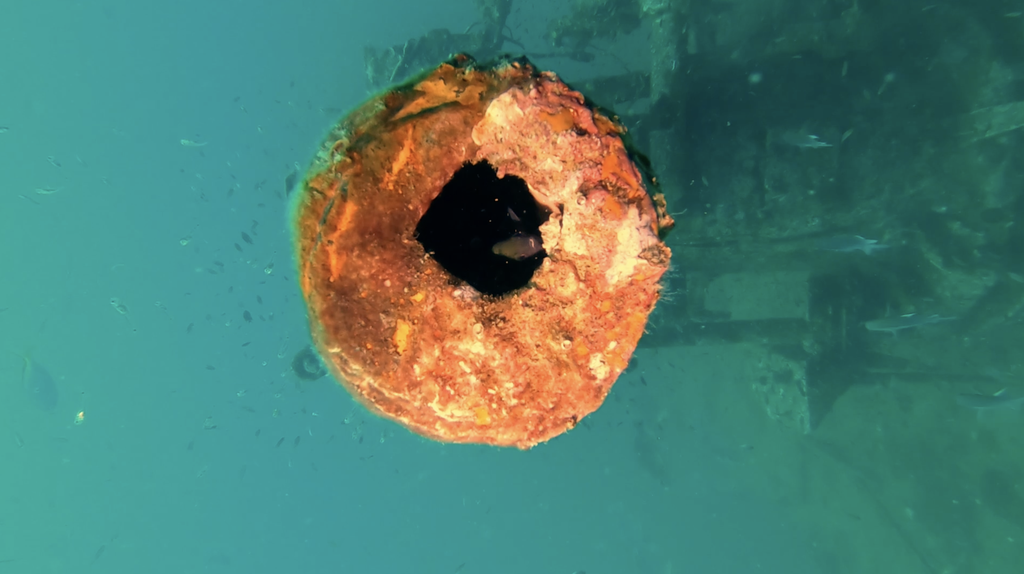

In [5]:
from io import BytesIO

with BytesIO(open(png_paths[0], "rb").read()) as img_bytes:
    # note: resizing is optional, but it helps with performance
    image = Image.open(img_bytes).resize(
        (1024, int(1024 * img.size[1] / img.size[0])),
        Image.Resampling.LANCZOS
    )
image

In [6]:
from google.genai import types

system_instruction = (
    "Describe what you see in this image, identify any fish or coral species "
    "in the image and tell us how many of each you can see."
)

safety_settings = [
    types.SafetySetting(
        category="HARM_CATEGORY_DANGEROUS_CONTENT",
        threshold="BLOCK_ONLY_HIGH",
    ),
]

config = types.GenerateContentConfig(
    system_instruction=system_instruction,
    temperature=0.1,
    safety_settings=safety_settings,
)

In [9]:
import os
from getpass import getpass
from google import genai

# pass your API key here
os.environ["GOOGLE_API_KEY"] = os.getenv("Gemini2-API-key") or getpass(
    "Enter Google API Key: "
)
# initialize our client
client = genai.Client()

Enter Google API Key: ··········


In [10]:
system_instruction = (
    "Return bounding boxes as a JSON array with labels. Never "
    "return masks or code fencing. Limit to 25 objects. "
    "If an object is present multiple times, label them according "
    "to their scientific and popular name."
)  # modifying this prompt much seems to damage performance

config = types.GenerateContentConfig(
    system_instruction=system_instruction,
    temperature=0.1,
    safety_settings=safety_settings,
)

In [13]:
import os
from getpass import getpass
from google import genai


os.environ["GOOGLE_API_KEY"] = "Gemini2-API-key"


client = genai.Client()

In [ ]:
response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight the different fish in the image",
        image
    ],
    config=config
)

Markdown(response.text)

In [ ]:
system_instruction = (
    "Return bounding boxes as a JSON array with labels. Never "
    "return masks or code fencing. Limit to 25 objects. "
    "If an object is present multiple times, label them according "
    "to their scientific and popular name."
)  # modifying this prompt much seems to damage performance

config = types.GenerateContentConfig(
    system_instruction=system_instruction,
    temperature=0.05,
    safety_settings=safety_settings,
    frequency_penalty=1.0,  # reduce repetition
)

response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight the different fish in the image",
        image
    ],
    config=config
)

Markdown(response.text)

In [ ]:
import re
import json

json_pattern = re.compile(r'```json\n(.*?)```', re.DOTALL)
json_output = json_pattern.search(response.text).group(1)

# convert our json string to a list of dicts
bounding_boxes = json.loads(json_output)
bounding_boxes

In [ ]:
from PIL import ImageDraw, ImageColor

colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def plot_bounding_boxes(image: Image, llm_output: str) -> Image:
    # avoid modifying the original image
    img = image.copy()
    # we need the image size to convert normalized coords to absolute below
    width, height = img.size
    # init drawing object
    draw = ImageDraw.Draw(img)
    # parse out the bounding boxes JSON from markdown
    bounding_boxes = parse_json(llm_output=llm_output)

    # iterate over LLM defined bounding boxes
    for i, bounding_box in enumerate(bounding_boxes):
      # set diff color for each box
      color = colors[i % len(colors)]

      # from normalized to absolute coords
      abs_y1 = int(bounding_box["box_2d"][0]/1000 * height)
      abs_x1 = int(bounding_box["box_2d"][1]/1000 * width)
      abs_y2 = int(bounding_box["box_2d"][2]/1000 * height)
      abs_x2 = int(bounding_box["box_2d"][3]/1000 * width)

      # coords might be going right to left, swap if so
      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1
      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1

      # draw the bounding boxes on our Draw object
      draw.rectangle(
          ((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=2
      )

      # draw text labels
      if "label" in bounding_box:
        draw.text((abs_x1 + 2, abs_y1 - 14), bounding_box["label"], fill=color)

    return img

In [ ]:
response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight the different corals in the image",
        image
    ],
    config=config
)

In [ ]:
response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight the different clownfish in the image",
        image
    ],
    config=config
)
plot_bounding_boxes(image, response.text)

In [ ]:
response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight any cleaner wrasse in this image",
        image
    ],
    config=config
)
plot_bounding_boxes(image, response.text)

In [ ]:
with BytesIO(open(png_paths[1], "rb").read()) as img_bytes:
    # note: resizing is optional, but it helps with performance
    image = Image.open(img_bytes).resize(
        (1024, int(1024 * img.size[1] / img.size[0])),
        Image.Resampling.LANCZOS
    )

response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight any fish in this image",
        image
    ],
    config=config
)
plot_bounding_boxes(image, response.text)

In [ ]:
response = client.models.generate_content(
    model=model_id,
    contents=[
        "What is the big fish in the middle of the image? Please highlight it.",
        image
    ],
    config=config
)
plot_bounding_boxes(image, response.text)

In [ ]:
with BytesIO(open(png_paths[2], "rb").read()) as img_bytes:
    # note: resizing is optional, but it helps with performance
    image = Image.open(img_bytes).resize(
        (1024, int(1024 * img.size[1] / img.size[0])),
        Image.Resampling.LANCZOS
    )

response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight any fish in this image",
        image
    ],
    config=config
)
plot_bounding_boxes(image, response.text)

In [ ]:
with BytesIO(open(png_paths[2], "rb").read()) as img_bytes:
    # note: resizing is optional, but it helps with performance
    image = Image.open(img_bytes).resize(
        (1024, int(1024 * img.size[1] / img.size[0])),
        Image.Resampling.LANCZOS
    )

response = client.models.generate_content(
    model=model_id,
    contents=[
        "Highlight the corals in this image",
        image
    ],
    config=config
)
plot_bounding_boxes(image, response.text)

In [ ]:
with BytesIO(open(png_paths[3], "rb").read()) as img_bytes:
    # note: resizing is optional, but it helps with performance
    image = Image.open(img_bytes).resize(
        (1024, int(1024 * img.size[1] / img.size[0])),
        Image.Resampling.LANCZOS
    )

response = client.models.generate_content(
    model=model_id,
    contents=[
        "Where is the fish hiding in this image?",
        image
    ],
    config=config
)
plot_bounding_boxes(image, response.text)

In [ ]:
system_instruction = (
    "Describe what you see in this image, identify any fish or coral species "
    "in the image and tell us how many of each you can see."
)

config = types.GenerateContentConfig(
    system_instruction=system_instruction,
    temperature=0.1,
    safety_settings=safety_settings,
)

response = client.models.generate_content(
    model=model_id,
    contents=[
        "Explain what this image contains, what is happening, and what is the location?",
        image
    ],
    config=config
)

Markdown(response.text)

In [ ]:
response = client.models.generate_content(
    model=model_id,
    contents=[
        "What is your best guess as to the exact location of this shipwreck?",
        image
    ],
    config=config
)

Markdown(response.text)